

# Project: Soccer Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

Soccer dataset , it is a large well organized data set which contains data about soccer teams,players,matches from different European countries from 2008 to 2016.It consists of eight tables {Country , League , Match , Player,Player_Attributes,sqllite_sequence,Team,Team_Attributes}


**Tables**:

1-Country : id,name

2-League : id,country_id (foreign_key from Country table ),name

3-Match : id,country_id(foreign_key from Country table),league_id(foreign_key from League table),season,stage,date,match_api_id,home_team_api_id,away_team_api_id(foreign key from Team table), 11 columns for each team indicating players starting the match coordinates (But they are all null values) ,Betting odds

4-Player : id,Player_api_id,player_name,Player_api_id,birthday,height,wight

5-Player_Attributes : id,player_fifa_api_id,date,overall,potential,preferred_foot,attacking,defensive,crossing,heading,finishing,short_pass,volleys,dribbling,curve,free_kick,long_pass,..etc

6-Team : id,team_api_id,team_fifa_api_id,team_long_name,team_short_name

7-Team_Attributes :id,Team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,..etc(other team evaluation metrics)

**Relations**:

-Each league is assocaited with a country via country_id.

-Each match is associated with a league and a country via league_id,country_id.

-Player attributes are associated with a certain player via palyer_api_id.

-Team attributes are associated with a certain team via team_api_id.


**Dataset**:

**.** +25,000 matches.

**.** +10,000 players.

**.** 11 European Countries with their lead championship.

**.** Seasons 2008 to 2016.

**.** Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates.

**.** Team line up with squad formation (X, Y coordinates).

**.** Betting odds from up to 10 providers.

**.** Detailed match events (goal types, possession, corner, cross, fouls, cards etc…) for +10,000 matches.


### Question(s) for Analysis

**Some important questions could be:**

-How many victories has a certian team achieved in a certain season?

-Which team achieved the most victories?

-What team attributes lead to the most victories?

-Which league has the most goals?

-What's the statistics of ages of players?

-What are the players' average overall and which players have the best overall mean ?

-What's the percentage of left-footed players ?

In [2]:
#Used packages.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
from datetime import date
from datetime import datetime

In [3]:
# Upgrade pandas to use dataframe.explode() function. 
#!pip install --upgrade pandas

<a id='wrangling'></a>
## Data Loading & Wrangling


In [4]:

#DATA LOADING
country=pd.read_csv("Database_Soccer/Country.csv")

league=pd.read_csv("Database_Soccer/League.csv")

match=pd.read_csv("Database_Soccer/Match.csv")

player=pd.read_csv("Database_Soccer/Player.csv")

player_attr=pd.read_csv("Database_Soccer/Player_Attributes.csv")

team=pd.read_csv("Database_Soccer/Team.csv")

team_attr=pd.read_csv("Database_Soccer/Team_Attributes.csv")


**Data Cleaning**

Most of the tables don't have much null values except for "matches" table , The null values in all tables are going to be dealt with.Also some columns have irrelevant data. 

**Null values are a huge problem as they affect the results if they are not dealt with properly. Drop columns with more than 20% null values , because there are columns with a large percent of null values.** 

In [5]:
dataframes=np.array([country,league,match,player,player_attr,team,team_attr])
for df in dataframes:
    df.dropna(thresh = len(df) * 0.8, axis = 1, inplace = True)
    

**After dropping columns with a large percentage of nulls , the remaining nulls should also be dealt with , this will be done by replacing remaining null values with the mean in order to smoothen the values.**

In [6]:
for df in dataframes:
    df.fillna(df.mean(),inplace=True)

**Preferred foot is not a numerical value so we can not fill the remaining null values with the average , however we will fill null preferred foot values with the value 'right' as it is the majority.**

In [7]:
player_attr['preferred_foot'].fillna('right',inplace=True)

**Drop the "attacking_work_rate" and the "defensive_work_rate" as it contains a large amount of null values as well as irrelevant values**

In [8]:
player_attr.drop(['attacking_work_rate','defensive_work_rate'],inplace=True,axis=1)

In [9]:
#Checking for no null values 
def check_df(df):
    return df.isna().sum().sum()
sum_null=0
for df in dataframes:
    sum_null+=check_df(df)
print(sum_null)    


0


<a id='eda'></a>
## Exploratory Data Analysis


### Research Question 1 (How many victories has a certian team achieved in a certain season?)


Create attribute winner based on number of goals.

In [10]:
match['winner']  = np.where(
    match['home_team_goal'] < match['away_team_goal'], match['away_team_api_id'], np.where(
    match['home_team_goal'] >  match['away_team_goal'], match['home_team_api_id'], -1 )) ;


**Function to answer the first question , by taking the object team and season as arguments the function returns number of victories of this team in a specific season.**

In [11]:
def no_of_victories(object_team , object_season):
    object_team =team[team['team_long_name']== object_team]['team_api_id']
    object_team=int(object_team)
    result=match[match.winner == object_team ]
    result=result[result.season==object_season]
    return result.shape[0]

no_of_victories('Liverpool','2012/2013')


16

### Research Question 2  (Which team achieved the most victories?)

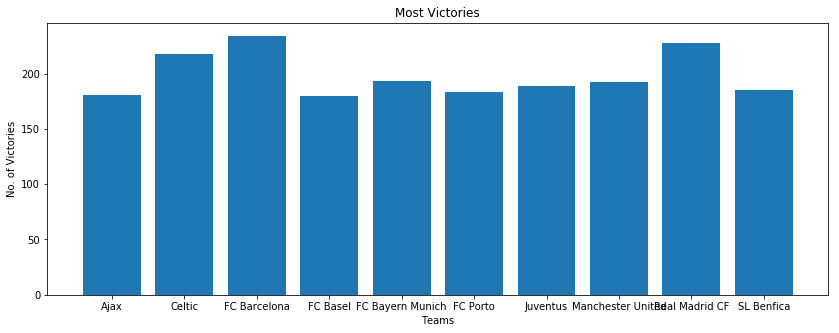

In [12]:
most_winners=match.groupby('winner')['winner'].count().sort_values(ascending=False)
values=np.array(most_winners)[1:11]
teams=np.array(most_winners.index)[1:11]

names = np.empty(10, dtype='object')
name=""
for i in range(0,10):
    name=str(team[team['team_api_id']==teams[i]]['team_long_name'])
    names[i]=name.split('\n')
    names[i]=names[i][0].split('  ')[2]
    
##creating the bar plot
fig = plt.figure(figsize = (14, 5))
plt.bar(names, values)
 
plt.xlabel("Teams")
plt.ylabel("No. of Victories")
plt.title("Most Victories")
plt.show()

**The above figure indicates the numbers of victories achieved by each team indicating FC Barcelona to be on the top.**

### Research Question 3  (Which team attributes lead to the most victories?)

**Some important merges**

In [13]:
team_joined =team.merge(team_attr, left_on='team_api_id', right_on='team_api_id', how='inner')
winner_attributes=team_joined.merge(match,left_on='team_api_id',right_on='winner',how='right')

In [14]:
winner_attributes.dropna(inplace=True)
winner_attributes.drop_duplicates(keep=False,inplace=True)
winner_attributes.drop_duplicates(subset='match_api_id',inplace=True)

**We will perform scatter plots between the difference in goals(which leads to victory) , some winner team attributes, in order to try to figure out the most important team attributes which lead to victories.**

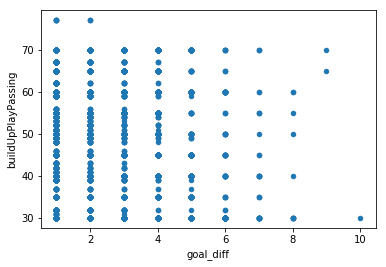

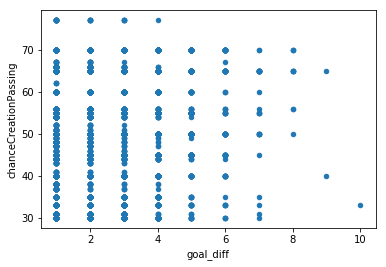

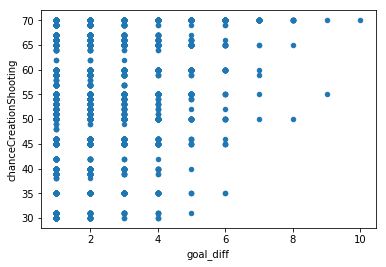

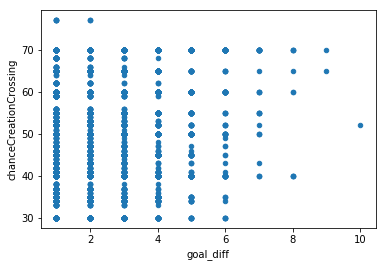

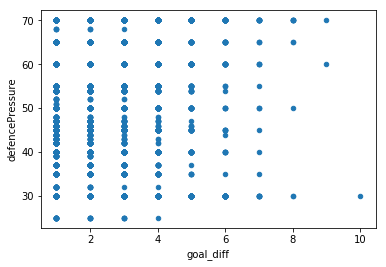

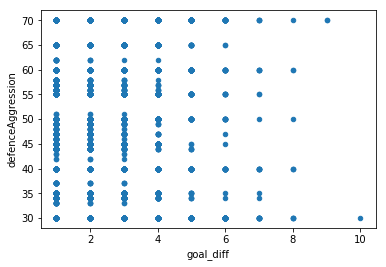

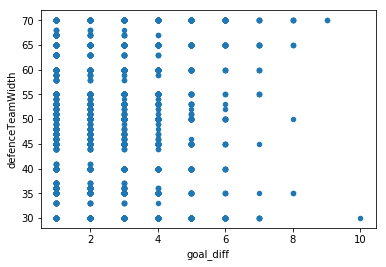

In [65]:
winner_attributes['goal_diff']=abs(winner_attributes['away_team_goal']-winner_attributes['home_team_goal'])
important_attributes=winner_attributes.iloc[:, np.r_[-1, 9:28]]
#numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#important_attributes=important_attributes.select_dtypes(include=numerics)
#sns.pairplot(important_attributes);
important_attributes.plot.scatter(x='goal_diff',y='buildUpPlayPassing');
important_attributes.plot.scatter(x='goal_diff',y='chanceCreationPassing');
important_attributes.plot.scatter(x='goal_diff',y='chanceCreationShooting');
important_attributes.plot.scatter(x='goal_diff',y='chanceCreationCrossing');
important_attributes.plot.scatter(x='goal_diff',y='defencePressure');
important_attributes.plot.scatter(x='goal_diff',y='defenceAggression');
important_attributes.plot.scatter(x='goal_diff',y='defenceTeamWidth');


We can observe that 'chanceCreationShooting' is the most attribute leading to victory(goal difference).

### Research Question 4 (Which league has the most goals?)

In [17]:
match['goals']=match['home_team_goal']+match['away_team_goal']
match_league =league.merge(match, left_on='id', right_on='league_id', how='left')



In [18]:
leagues_goals=match_league.groupby('name').count().sort_values(by='goals',ascending=False)['goals']

**The following bar chart shows the number of goals in each of the european leagues.**

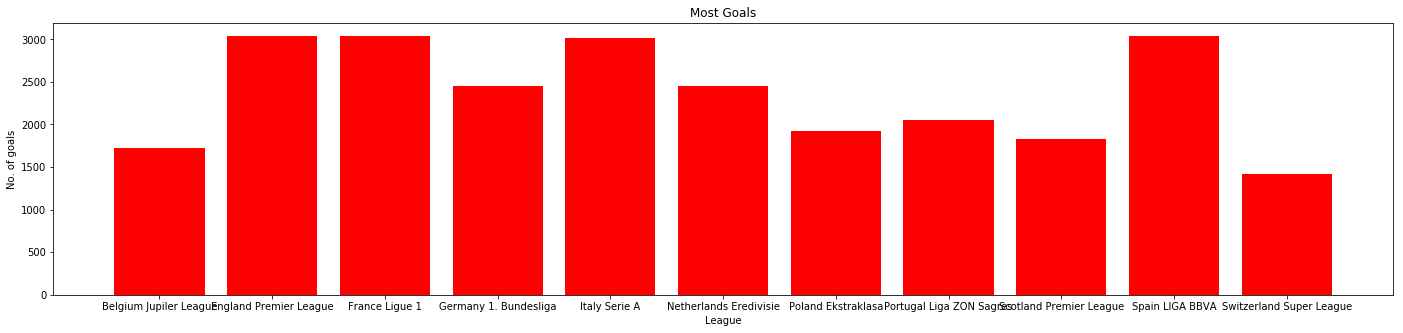

In [19]:
##creating the bar plot
fig = plt.figure(figsize = (24, 5))
plt.bar(leagues_goals.index,leagues_goals,color='red')
 
plt.xlabel("League")
plt.ylabel("No. of goals")
plt.title("Most Goals")
plt.show()

### Research Question 5 (What's the statistics of ages of players?)


**note: Age is calculated relative to year 2016**

Statistics were done on players ages in the following cell.

In [47]:
result=[]
for i in range(len(player)):
    result.append(2016-int(player['birthday'][i].split('-')[0]))
player['age']=result  
player['age'].describe()


count    11060.000000
mean        29.357143
std          5.481362
min         17.000000
25%         25.000000
50%         29.000000
75%         33.000000
max         49.000000
Name: age, dtype: float64

### Research Question 6 (What are the players' average overall and which players have the best overall mean?)

In [49]:
player_total =player.merge(player_attr, left_on='player_api_id', right_on='player_api_id', how='left')

In [50]:
overall_mean=player_total.groupby('player_name')['overall_rating'].mean().sort_values(ascending=False)
print(overall_mean[:10])

player_name
Lionel Messi          92.192308
Cristiano Ronaldo     91.280000
Franck Ribery         88.458333
Andres Iniesta        88.320000
Zlatan Ibrahimovic    88.285714
Arjen Robben          87.840000
Xavi Hernandez        87.636364
Wayne Rooney          87.222222
Iker Casillas         86.954545
Philipp Lahm          86.733333
Name: overall_rating, dtype: float64


In [51]:
overall_mean.describe()

count    10848.000000
mean        66.802762
std          6.204185
min         43.000000
25%         62.841103
50%         66.715477
75%         70.889881
max         92.192308
Name: overall_rating, dtype: float64

**In the following histogram thee overall rating of players have been plotted indicating most players are in the range 60-70 , the distribution seems to be uniform.**

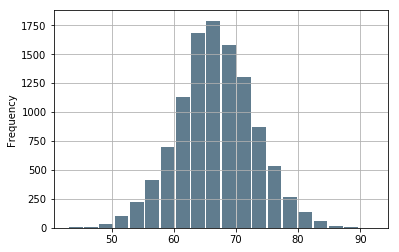

In [52]:
overall_mean.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e');

### Research Question 7 (What is the percentage of left-footed  players?)

Percentage of left-footed players is calculated by dividing the number of left-footed players by the total number of players 

In [64]:
preferred_foot=player_total['preferred_foot'].value_counts()
print(preferred_foot)
print('Left footed players represent about ',preferred_foot[1]/(preferred_foot[0]+preferred_foot[1]),'%')

right    139245
left      44733
Name: preferred_foot, dtype: int64
Left footed players represent about  0.243143201905 %


<a id='conclusions'></a>
## Conclusions

**The results here showed the required answers for the questions we had by manipulating the needed data to help answering each question.**

**We first have been able to specify number of victories of a specific team in a certain season**

For example 'FC Barcelona'managed in'2009/2010' to win 31 matches.

'Liverpool' managed in 2012/2013 to win 16 matches.

**Secondly, We observed the top teams with the greatest number of victories in all seasons**

It was observed that FC Barcelona came first , Real Madrid in the second position and Celtic Fc in the third.

**Thirdly, which I find was the most challenging, scatter plots were plotted to indicate relations between different teams' attributes across the goal difference in each match**

Actually the relations were not that clear maybe because the goal difference does not fully describe victory but I think it is still the most well describing way to describe victory(goals).

**Fourthly**,An important question was which leagues had the most scored goals , It was found that the most scoring leagues were 
(English premiere league , France ligue1 , Italy Serie A ,Spain Liga)

**Fifthly**, Statistics of players' ages were dont to show the minimum , maximum and average players' ages, It was observed that the youngest player was 17 years old , the oldest was 49(such a hero!) and the average was around 29 years which is considered the prime of most football players.

**Sixthly**, A very important question was concerning the overall rating of players , it was observed that the highest overall rating mean was for the legend Lionel Messi followed by his all time rival the great CR7 which are both considered to be among the best players of all time , they had average overall rating of 92.2 ,91.3 respectively while the average players were about 68 overall rating.

**Finally** An easy yet important question was the percentage of left-footed players , It is a shock that only 0.24% of players are left footed while about 12% of people are. However filling the null values in this column with 'right footed' value may have affected this ratio .

## Limitations

**Issues with the dataset**:
-Some tables specially the match table has lots of null values .
-Some relevant data should be added to the collection , ex: Team's coach 
**Analysis issues**:
One main point was the analysis of teams victories , This analysis has been done in the scope of the report baased on the goal difference in each match , maybe further data would improve this field of analysis.

In [66]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0